In [1]:
from PIL import Image
from rl_benchmarks.models import iBOTViT
from openslide import open_slide
from openslide.deepzoom import DeepZoomGenerator
import pathlib
from tqdm import tqdm
from PIL import Image
import numpy as np
Image.MAX_IMAGE_PIXELS = None
from torchvision import transforms
import torch
from torch.utils.data import Dataset
import os
from multiprocessing import Pool
import umap
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from rl_benchmarks.utils.linear_evaluation import get_binary_class_metrics, get_bootstrapped_metrics, dict_to_dataframe
import umap.plot

/home/yuxin/miniconda3/envs/histosslscaling/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
weights_path = '/home/yuxin/Downloads/ibot_vit_base_pancan.pth'
ibot_base_pancancer = iBOTViT(architecture="vit_base_pancan", encoder="student", weights_path=weights_path).to(device)

2023-12-06 09:58:17.953 | INFO     | rl_benchmarks.models.feature_extractors.ibot_vit:__init__:78 - Pretrained weights found at /home/yuxin/Downloads/ibot_vit_base_pancan.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['masked_embed', 'head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v', 'head.last_layer2.weight_g', 'head.last_layer2.weight_v'])


In [3]:
patch_size = 224
data_root = pathlib.Path('/mnt/hd0/ssd/SUQH_10x336')
phases = ['train', 'val', 'test']
save_root = pathlib.Path('/mnt/hd0/project_large_files/bcacad/suqh_10x_336_features')
save_root.mkdir(exist_ok=True)
data_trans = transforms.Compose([
                                transforms.Resize(patch_size),
                                ibot_base_pancancer.transform,
                                ])

In [4]:
def get_type_grade(path):
    type_grade = path.parent.name
    if type_grade == 'normal':
        return 0,0
    elif type_grade == 'tis-1':
        return 1,0
    elif type_grade == 'tis-2':
        return 1,1
    elif type_grade == 'tis-3':
        return 1,2
    elif type_grade == 'it-1':
        return 2,0
    elif type_grade == 'it-2':
        return 2,1
    elif type_grade == 'it-3':
        return 2,2

In [16]:
def get_X_Y(data_root, save_root, phases=['test']):
    X={}
    Y={}
    for task in ['type', 'nonibc', 'ibc']:
        X[task] = {}
        Y[task] = {}
        for phase in phases:
            X[task][phase] = []
            Y[task][phase] = []

    for phase in phases:
        phase_root = data_root / phase
        tile_paths = list(phase_root.glob('**/*.jpg'))
        for path in tqdm(tile_paths, desc=f'Processing {phase}'):
            save_path = save_root / phase / path.parent.name /f'{path.stem}.npy' 
            if save_path.exists():
                feature = np.load(save_path)
            else:
                save_path.parent.mkdir(exist_ok=True, parents=True)
                im = Image.open(path)
                tensor = data_trans(im)
                batch = tensor.unsqueeze(0)
                batch = batch.to(device)
                feature = ibot_base_pancancer(batch).detach().cpu().numpy()
                feature = feature.flatten()
                np.save(save_path, feature)

            type, grade = get_type_grade(path)
            
            X['type'][phase].append(feature)
            Y['type'][phase].append(type)

            if type == 1:
                X['nonibc'][phase].append(feature)
                Y['nonibc'][phase].append(grade)
            elif type == 2:
                X['ibc'][phase].append(feature)
                Y['ibc'][phase].append(grade)
    return X, Y

In [5]:
X={}
Y={}
for task in ['type', 'nonibc', 'ibc']:
    X[task] = {}
    Y[task] = {}
    for phase in phases:
        X[task][phase] = []
        Y[task][phase] = []

for phase in phases:
    phase_root = data_root / phase
    tile_paths = list(phase_root.glob('**/*.jpg'))
    for path in tqdm(tile_paths, desc=f'Processing {phase}'):
        save_path = save_root / phase / path.parent.name /f'{path.stem}.npy' 
        if save_path.exists():
            feature = np.load(save_path)
        else:
            save_path.parent.mkdir(exist_ok=True, parents=True)
            im = Image.open(path)
            tensor = data_trans(im)
            batch = tensor.unsqueeze(0)
            batch = batch.to(device)
            feature = ibot_base_pancancer(batch).detach().cpu().numpy()
            feature = feature.flatten()
            np.save(save_path, feature)

        type, grade = get_type_grade(path)
        
        X['type'][phase].append(feature)
        Y['type'][phase].append(type)

        if type == 1:
            X['nonibc'][phase].append(feature)
            Y['nonibc'][phase].append(grade)
        elif type == 2:
            X['ibc'][phase].append(feature)
            Y['ibc'][phase].append(grade)

Processing test: 100%|██████████| 47330/47330 [00:17<00:00, 2679.28it/s]


In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(confusion_matrix, labels):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.title('Confusion Matrix')
    plt.show()

In [7]:
def get_metrics(labels, scores, class_names, phase='test'):
    n_resamples = 1000
    confidence_level = 0.95

    binary_metrics = {phase:get_binary_class_metrics(labels, scores)}
    bootstrapped_metrics = {phase: get_bootstrapped_metrics(
        labels, scores, n_resamples=n_resamples, confidence_level=confidence_level
    )}

    results_dict = {
        "binary": binary_metrics,
        "bootstrap": bootstrapped_metrics,
    }
    
    results = dict_to_dataframe(
        results_dict, metrics=["auc", "acc", "f1"], class_names=class_names
    )
    return results


In [8]:
models = {}
for task in ['type', 'nonibc', 'ibc']:
    model = sklearn.linear_model.SGDClassifier(
                loss="log_loss",
                penalty="l2",
                learning_rate="adaptive",
                eta0=1e-4,
                n_jobs=8,
                early_stopping=False,
                random_state=2023,
            ).fit(np.array(X[task]['train']+X[task]['val']), np.array(Y[task]['train']+Y[task]['val']))
    models[task] = model

type


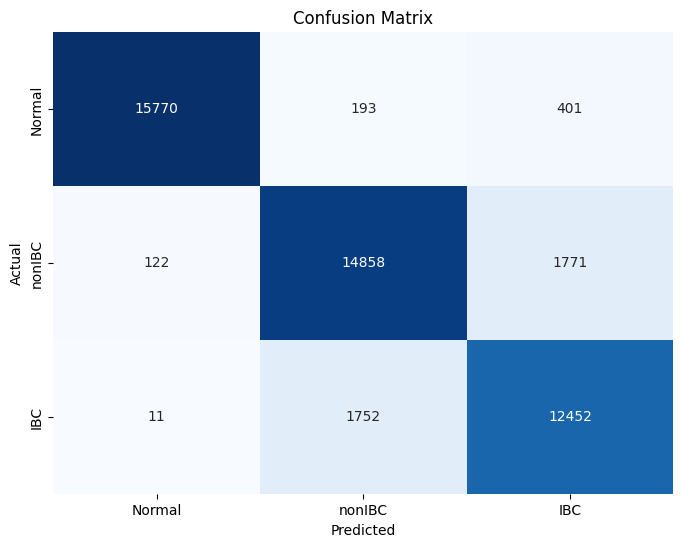


[[15770   193   401]
 [  122 14858  1771]
 [   11  1752 12452]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.999  |  0.0   |   0.999   |   0.999   |
|   1   | 0.9722 |  0.0   |   0.9722  |   0.9722  |
|   2   | 0.9665 | 0.0001 |   0.9664  |   0.9665  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.9775  |   0.9916  | 0.9637 |    0.9957   | 0.9811 |  16364  |
|      1       |  0.8856  |   0.8842  | 0.887  |    0.9364   | 0.938  |  16751  |
|      2       |  0.8636  |   0.8515  | 0.876  |    0.9344   | 0.9461 |  14215  |
|              |          |           |        |             |        |       

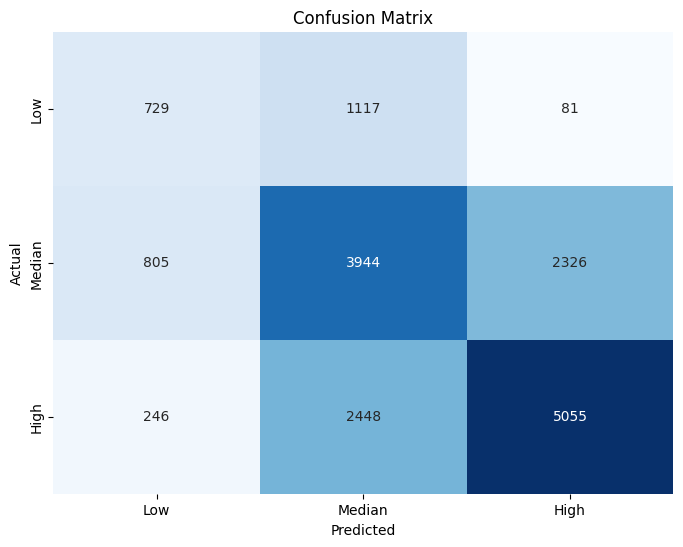


[[ 729 1117   81]
 [ 805 3944 2326]
 [ 246 2448 5055]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.7977 | 0.0003 |   0.7974  |   0.798   |
|   1   | 0.6192 | 0.0003 |   0.6189  |   0.6195  |
|   2   | 0.758  | 0.0002 |   0.7578  |   0.7583  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.3933  |   0.4096  | 0.3783 |    0.9291   |  0.92  |   1927  |
|      1       |  0.5409  |   0.5252  | 0.5575 |    0.6316   | 0.6612 |   7075  |
|      2       |  0.6647  |   0.6774  | 0.6523 |    0.7326   |  0.71  |   7749  |
|              |          |           |        |             |        |         |
|   a

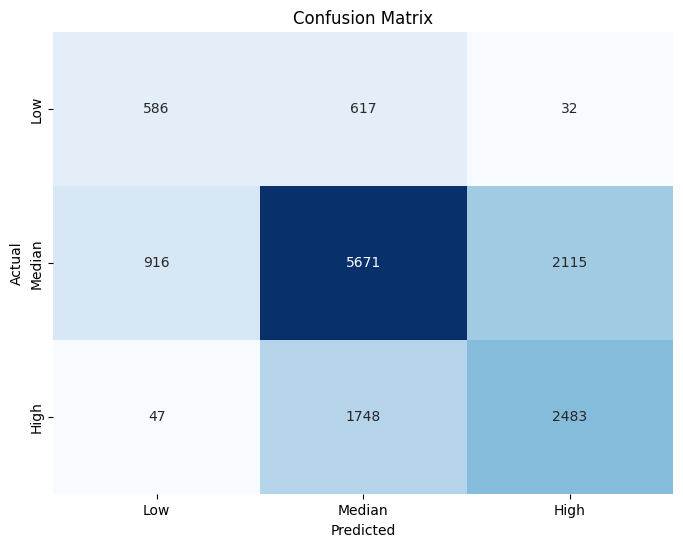


[[ 586  617   32]
 [ 916 5671 2115]
 [  47 1748 2483]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.7916 | 0.0005 |   0.7911  |   0.7921  |
|   1   | 0.6443 | 0.0003 |   0.644   |   0.6446  |
|   2   | 0.7665 | 0.0003 |   0.7662  |   0.7667  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.421   |   0.3783  | 0.4745 |    0.9258   | 0.9488 |   1235  |
|      1       |  0.6776  |   0.7057  | 0.6517 |    0.571    | 0.5095 |   8702  |
|      2       |  0.5575  |   0.5363  | 0.5804 |    0.7839   | 0.8127 |   4278  |
|              |          |           |        |             |        |         |
|   a

In [11]:
from metrics3 import report

tasks = ['type', 'nonibc', 'ibc']
class_names = {
    'type': ['Normal', 'nonIBC', 'IBC'],
    'nonibc': ['Low', 'Medium', 'High'],
    'ibc': ['Low', 'Medium', 'High'],
}

for task in tasks:
    model = models[task]
    preds = model.predict(np.array(X[task]['test']))
    probs = model.predict_proba(np.array(X[task]['test']))
    labels = np.array(Y[task]['test'])
    print(task)
    cm = confusion_matrix(labels, preds)
    plot_confusion_matrix(cm, class_names[task])
    print(report(labels, preds, probs, class_names[task]))




In [18]:
qingdao_root = pathlib.Path('/mnt/hd0/project_large_files/bcacad/patches/qingdao_test')
qingdao_save_root = pathlib.Path('/mnt/hd0/project_large_files/bcacad/patches/qingdao_test/test_ssl_features')
qingdao_X, qingdao_Y = get_X_Y(qingdao_root, qingdao_save_root, phases=['test'])

Processing test: 100%|██████████| 5453/5453 [01:33<00:00, 58.42it/s]


type


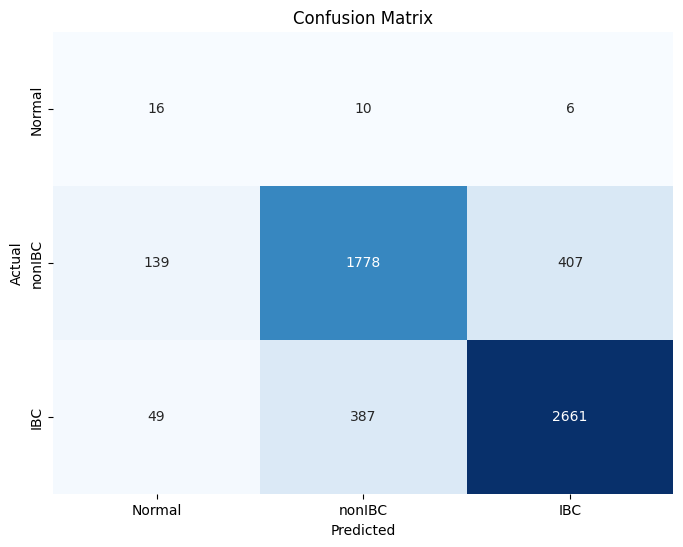


[[  16   10    6]
 [ 139 1778  407]
 [  49  387 2661]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.9265 | 0.0009 |   0.9256  |   0.9274  |
|   1   | 0.8948 | 0.0003 |   0.8945  |   0.8951  |
|   2   | 0.9182 | 0.0002 |   0.918   |   0.9184  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.1356  |   0.0784  |  0.5   |    0.9653   | 0.997  |    32   |
|      1       |  0.7904  |   0.8175  | 0.7651 |    0.8731   | 0.8334 |   2324  |
|      2       |  0.8624  |   0.8656  | 0.8592 |    0.8247   | 0.8167 |   3097  |
|              |          |           |        |             |        |         |
|   a

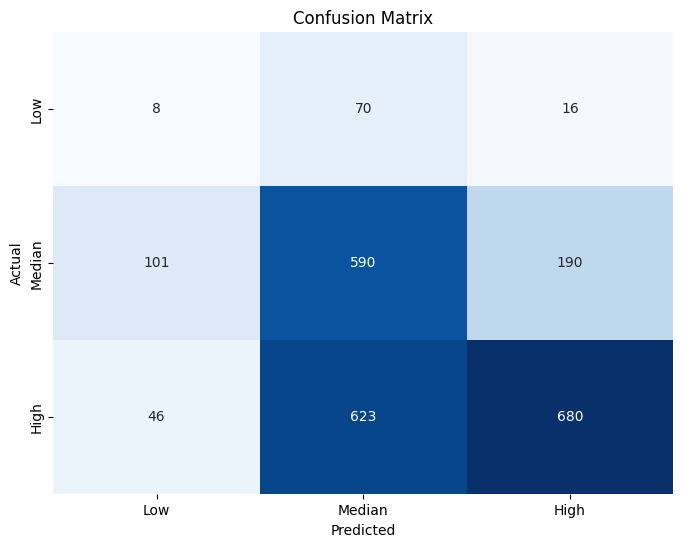


[[  8  70  16]
 [101 590 190]
 [ 46 623 680]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.7056 | 0.0014 |   0.7041  |   0.707   |
|   1   | 0.6086 | 0.0007 |   0.6079  |   0.6093  |
|   2   | 0.6766 | 0.0007 |   0.6759  |   0.6773  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.0643  |   0.0516  | 0.0851 |    0.9341   | 0.9604 |    94   |
|      1       |  0.5453  |   0.4599  | 0.6697 |    0.5198   | 0.7205 |   881   |
|      2       |  0.6085  |   0.7675  | 0.5041 |    0.7887   | 0.5348 |   1349  |
|              |          |           |        |             |        |         |
|   accuracy  

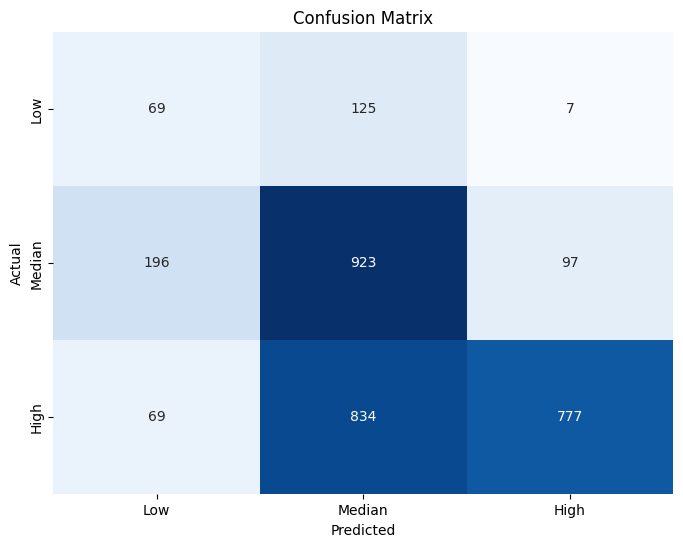


[[ 69 125   7]
 [196 923  97]
 [ 69 834 777]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.8066 | 0.0008 |   0.8058  |   0.8074  |
|   1   | 0.6745 | 0.0006 |   0.6739  |   0.6751  |
|   2   | 0.8214 | 0.0005 |   0.8209  |   0.8218  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.2579  |   0.2066  | 0.3433 |    0.9085   | 0.9522 |   201   |
|      1       |  0.5959  |   0.4904  | 0.759  |    0.4902   | 0.7588 |   1216  |
|      2       |  0.6068  |   0.882   | 0.4625 |    0.9266   | 0.5925 |   1680  |
|              |          |           |        |             |        |         |
|   accuracy  

In [19]:
for task in tasks:
    model = models[task]
    preds = model.predict(np.array(qingdao_X[task]['test']))
    probs = model.predict_proba(np.array(qingdao_X[task]['test']))
    labels = np.array(qingdao_Y[task]['test'])
    print(task)
    cm = confusion_matrix(labels, preds)
    plot_confusion_matrix(cm, class_names[task])
    print(report(labels, preds, probs, class_names[task]))

In [21]:
shandaer_root = pathlib.Path('/mnt/hd0/project_large_files/bcacad/patches/shandaer_test')
shandaer_save_root = pathlib.Path('/mnt/hd0/project_large_files/bcacad/patches/shandaer_test/test_ssl_features')
shandaer_X, shandaer_Y = get_X_Y(shandaer_root, shandaer_save_root, phases=['test'])

Processing test:   0%|          | 0/4545 [00:00<?, ?it/s]

Processing test: 100%|██████████| 4545/4545 [01:16<00:00, 59.07it/s]


type


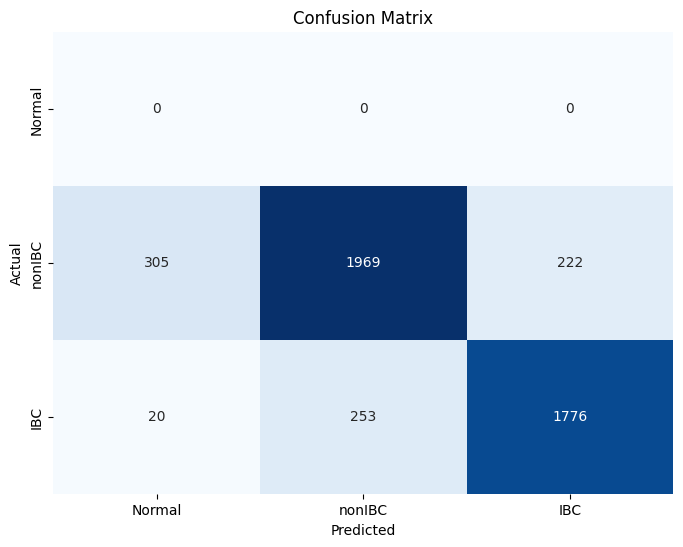

/home/yuxin/miniconda3/envs/histosslscaling/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/yuxin/miniconda3/envs/histosslscaling/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuxin/miniconda3/envs/histosslscaling/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yuxin/miniconda3/envs/histosslscaling/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuxin/miniconda3/envs/histosslscaling/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arr


[[   0    0    0]
 [ 305 1969  222]
 [  20  253 1776]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   |  nan   |  nan   |    nan    |    nan    |
|   1   | 0.8932 | 0.0003 |   0.8929  |   0.8935  |
|   2   | 0.9549 | 0.0002 |   0.9547  |   0.9551  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |   0.0    |    0.0    |  0.0   |    0.9285   |  1.0   |    0    |
|      1       |  0.8347  |   0.8861  | 0.7889 |    0.8765   | 0.7731 |   2496  |
|      2       |  0.8777  |   0.8889  | 0.8668 |    0.9111   | 0.8928 |   2049  |
|              |          |           |        |             |        |         |
|   a

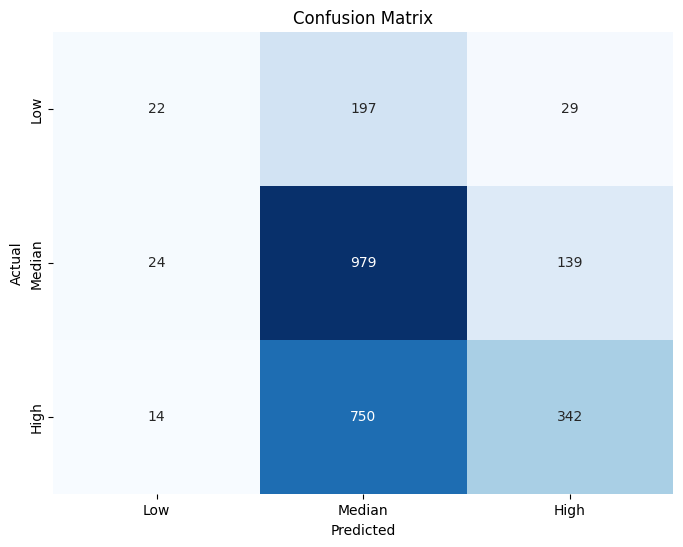


[[ 22 197  29]
 [ 24 979 139]
 [ 14 750 342]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.6764 | 0.0012 |   0.6752  |   0.6776  |
|   1   | 0.6447 | 0.0007 |   0.644   |   0.6453  |
|   2   | 0.6712 | 0.0007 |   0.6705  |   0.6718  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.1429  |   0.3667  | 0.0887 |    0.9831   | 0.9072 |   248   |
|      1       |  0.6382  |   0.5083  | 0.8573 |    0.3006   | 0.714  |   1142  |
|      2       |  0.4233  |   0.6706  | 0.3092 |    0.8791   | 0.6153 |   1106  |
|              |          |           |        |             |        |         |
|   accuracy  

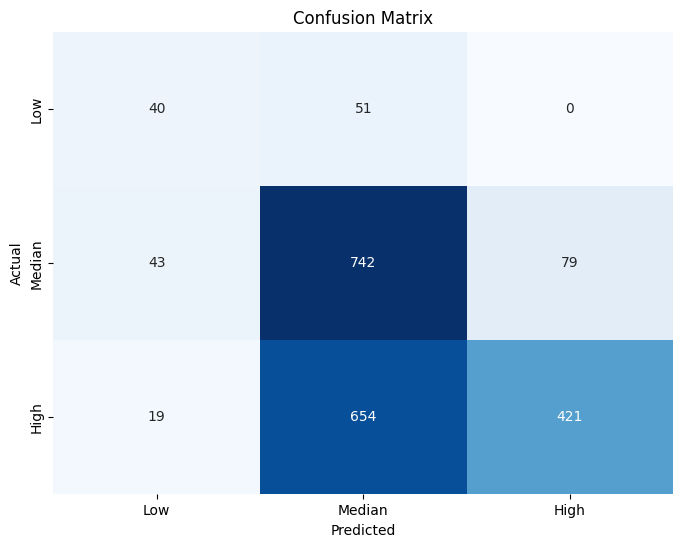


[[ 40  51   0]
 [ 43 742  79]
 [ 19 654 421]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.8923 | 0.0011 |   0.8912  |   0.8933  |
|   1   | 0.6548 | 0.0007 |   0.6541  |   0.6555  |
|   2   | 0.7375 | 0.0007 |   0.7369  |   0.7382  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.4145  |   0.3922  | 0.4396 |    0.9683   | 0.9738 |    91   |
|      1       |  0.6421  |   0.5128  | 0.8588 |    0.4051   | 0.7973 |   864   |
|      2       |  0.5282  |   0.842   | 0.3848 |    0.9173   | 0.5655 |   1094  |
|              |          |           |        |             |        |         |
|   accuracy  

In [22]:
for task in tasks:
    model = models[task]
    preds = model.predict(np.array(shandaer_X[task]['test']))
    probs = model.predict_proba(np.array(shandaer_X[task]['test']))
    labels = np.array(shandaer_Y[task]['test'])
    print(task)
    cm = confusion_matrix(labels, preds)
    plot_confusion_matrix(cm, class_names[task])
    print(report(labels, preds, probs, class_names[task]))